<a href="https://colab.research.google.com/github/mmeisser/python_tools/blob/master/test_PARSE_%26_PROCESS_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROCESS loadcell raw values

This notebook/python script does read log files collected with akra (v1.26.4 or above)

## 1. LOAD

First select the file to upload:
(run the below code section)

In [ ]:
from google.colab import files
uploaded = files.upload()

#uploaded #uncomment to check the content of file



Saving AkraLog_Playback_137_short.csv to AkraLog_Playback_137_short.csv


Then load the (selected) file into a (panda) data frame

In [ ]:
import pandas as pd
import io

file_to_analyze = 'AkraLog_Playback_137_short.csv'

df = pd.read_csv(io.StringIO(uploaded[file_to_analyze].decode('utf-8')))
#df #uncomment to show the loaded table

## 2. GRAPH

Process the data and spit out a graph

In [ ]:
import plotly.graph_objs as go
import csv
import matplotlib.pyplot as plt
import plotly.express as px


is_primary = df[' Device type']== ' Primary' #this is a column with true/false to assert if this is data for a controller
stylus_data = df[is_primary]    #therefore we only take that subset of lines for the controller (ie stylus)

nib=stylus_data[' Touchpad X value']*32768
primary=stylus_data[' Touchpad Y value']*32768
time=stylus_data['TimeStamp (ms)']


# plot graph with all series
fig = go.Figure([
    go.Scatter(
        name='Nib',
        y=nib,
        mode='lines',
        marker=dict(color='blue', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='Primary',
        y=primary,
        mode='lines',
        marker=dict(color='red', size=2),
        showlegend=True
    ),
    go.Scatter(
        name='minimum_nib',
        y=minimum_nib_array,
        mode='lines',
        marker=dict(color='pink', size=2),
        showlegend=True
    ), 
    go.Scatter(
        name='minimum_pri',
        y=minimum_pri_array,
        mode='lines',
        marker=dict(color='pink', size=2),
        showlegend=True
    )
])
fig.update_layout(
    yaxis_title='adc raw value [counts]',
    title=file_to_analyze,
    hovermode="x"
)
fig.show()

##3. ANALYSIS

In [ ]:
s = pd.Series(nib) #create a panda serie from NIB LOADCELL data
s.describe() #prints out stats data on serie

t = pd.Series(time) #create a panda serie from time data
t.diff()   #gives differences between samples in serie


# detect baseline (simple minimum for now) for NIB
minimum_nib = nib.array[0]
minimum_nib_array = nib.copy()

for index, value in enumerate(nib.array):
 if value < minimum_nib:
   minimum_nib = value #if we found a smaller value
 #print("Index:"+ str(index) + " - min" + str(minimum_nib))
 minimum_nib_array.array[index] = minimum_nib # place it into the array
#plt.plot(minimum_nib_array)

# detect baseline (simple minimum for now) for NIB
minimum_pri = primary.array[0]
minimum_pri_array = primary.copy()

for index, value in enumerate(primary.array):
 if value < minimum_pri:
   minimum_pri = value
 #print("Index:"+ str(index) + " - min" + str(minimum_pri))
 minimum_pri_array.array[index] = minimum_pri
#plt.plot(minimum_pri_array)

First setup some variable params

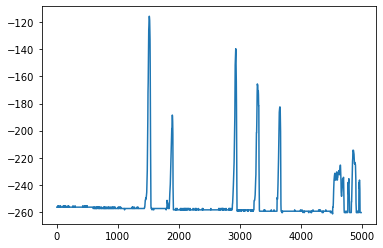

In [ ]:
#@title Variable Parameters { run: "auto", form-width: "50%" }
#last_frame = nib.count()
first_frame = 0 #@param {type:"integer"}
last_frame = 1660 #@param {type:"integer"}
gF_ADC_count = 2 #@param {type:"slider", min:0, max:2, step:0.1}

plt.plot(nib.iloc[first_frame:last_frame])

Here you can plot how the minimum values captured in the log do change overtime

NIB: min=-261.503909888 max=-115.50195712
PRI: min=-63.499993088000004 max=-19.5000008704


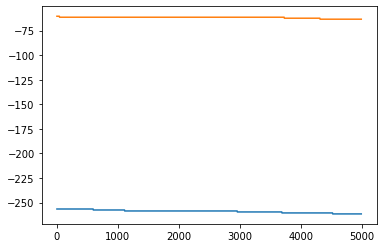

In [ ]:
plt.plot(minimum_nib_array.iloc[first_frame:last_frame])
plt.plot(minimum_pri_array.iloc[first_frame:last_frame])

print("NIB: min="+str(nib.iloc[first_frame:last_frame].min())+ " max="+ str(nib.iloc[first_frame:last_frame].max()))
print("PRI: min="+str(primary.iloc[first_frame:last_frame].min())+ " max="+ str(primary.iloc[first_frame:last_frame].max()))

## Evaluate the ACTIVITY

algos parameters

In [ ]:
Tolerance Margin   = 14	    #counts
Baseline Margin	   = 2	    #counts
Activity Margin	   = 3	    #counts
Baseline Threshold = 2	    #counts
Filter Threshold	 = 0.25	  #NA
Activity Window	   = 10	    #samples
Filter Window	     = 20 	  #samples
Raw Window	       = 10	    #samples
Raw Weight Min	   = 9	    #samples
Raw Weight Max	   = 1	    #samples
Elastic Force	     = 23	    #gf
Time Constant	     = 105	  #samples
Max Force	         = 400	  #gf




**Activity window**
is a sliding window of 10 sample

In [ ]:
for index, value in enumerate(nib.array):
 min = nib.iloc[index*10:index*10+9].min()
 max = nib.iloc[index*10:index*10+9].max()
 print("Index:%d - min:%d - max:%d" %( index,min, max) ) 

Index:0 - min:-256 - max:-255
Index:1 - min:-256 - max:-255
Index:2 - min:-256 - max:-255
Index:3 - min:-256 - max:-255
Index:4 - min:-256 - max:-255
Index:5 - min:-256 - max:-256
Index:6 - min:-256 - max:-255
Index:7 - min:-256 - max:-256
Index:8 - min:-256 - max:-255
Index:9 - min:-256 - max:-256
Index:10 - min:-256 - max:-256
Index:11 - min:-256 - max:-256
Index:12 - min:-256 - max:-256
Index:13 - min:-256 - max:-256
Index:14 - min:-256 - max:-255
Index:15 - min:-256 - max:-255
Index:16 - min:-256 - max:-255
Index:17 - min:-256 - max:-256
Index:18 - min:-256 - max:-256
Index:19 - min:-257 - max:-256
Index:20 - min:-257 - max:-256
Index:21 - min:-257 - max:-256
Index:22 - min:-257 - max:-256
Index:23 - min:-257 - max:-256
Index:24 - min:-257 - max:-256
Index:25 - min:-257 - max:-256
Index:26 - min:-257 - max:-256
Index:27 - min:-257 - max:-256
Index:28 - min:-257 - max:-256
Index:29 - min:-257 - max:-256
Index:30 - min:-257 - max:-256
Index:31 - min:-257 - max:-256
Index:32 - min:-25

ValueError: ignored

In [ ]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
# (in python 2 use xrange() instead of range() to avoid allocating a list)

text = "I am a very, very helpful text"

for group in chunker(nib, 10):
   #print(repr(group),)
   group.describe()